# Natural Computing - Assignment 1 - Evolutionary Computation
## Exercise 8 - Genetic Programming Behaviour
#### Submission by group 25 (Chihab Amghane, Max Driessen, Jordy Naus)

This file contains our solution to exercise 8 of the "Evolutionary Computation" assignment of the Natural Computing course.<br><br>
The code below uses the DEAP framework (https://github.com/deap/deap), which is a very intuitive framework for evolutionary algorithms and genetic programming.

### Installing the DEAP framework

In [1]:
!pip install deap

### Imports

In [2]:
from deap import gp, base, tools, creator, algorithms
import numpy as np
import matplotlib.pyplot as plt
import operator
import math

%matplotlib inline

### Constants

In [3]:
POP_SIZE = 1000
N_GENERATIONS = 50
CROSSOVER_PROB = 0.7
MUTATION_PROB = 0.0

CONTROL_BLOAT = False

### Defining the fitness function

In [4]:
solution_dict = {-1.0 :  0.0000, 
                 -0.9 : -0.1629, 
                 -0.8 : -0.2624, 
                 -0.7 : -0.3129, 
                 -0.6 : -0.3264, 
                 -0.5 : -0.3125, 
                 -0.4 : -0.2784, 
                 -0.3 : -0.2289, 
                 -0.2 : -0.1664, 
                 -0.1 : -0.0909, 
                  0.0 : 0.0, 
                  0.1 : 0.1111, 
                  0.2 : 0.2496, 
                  0.3 : 0.4251, 
                  0.4 : 0.6496, 
                  0.5 : 0.9375, 
                  0.6 : 1.3056, 
                  0.7 : 1.7731, 
                  0.8 : 2.3616, 
                  0.9 : 3.0951, 
                  1.0 : 4.0000}

In [5]:
def fitness(individual, points):
    # Transform tree expression into callable function
    func = toolbox.compile(expr=individual)
    # Compute sum of absolute errors
    error = 0
    for x, y in points.items():
        error += abs(func(x) - y)
    return -error,

### Defining the set of operators and terminals

In [6]:
def div(a,b):
    # Ensure no division by 0 takes place
    return a/b if b else 0

def log(a):
    # Ensure no logarithm is taken of a non-positive value
    return math.log(a) if (a > 0) else 0

def exp(a):
    # Ensure no exponential is too big
    return math.exp(min(a,100))


# Create set of functions and terminals, with one terminal: x
pset = gp.PrimitiveSet("main", 1)
pset.renameArguments(ARG0="x")

# Add all operators to the set
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(div, 2)
pset.addPrimitive(log, 1)
pset.addPrimitive(exp, 1)
pset.addPrimitive(math.sin, 1)
pset.addPrimitive(math.cos, 1)

### Define the creator that creates individuals (i.e. trees)

In [7]:
creator.create("FitnessMin", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

### Define the toolbox 
<b>(describes how to form a population, compile an expression as a function, evaluate fitness, select parents, perform cross-over and mutation)</b>

In [8]:
toolbox = base.Toolbox()
# Initial generation is generated using ramped half-and-half initialization, with a tree size between 1 and 5
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=5)
# Define how to generate a population of individuals
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# Define how to compile a tree as a function that can be evaluated
toolbox.register("compile", gp.compile, pset=pset)
# Define how to determine the fitness of an individual (using the fitness function defined above)
toolbox.register("evaluate", fitness, points=solution_dict)

# Define how to select parents (tournament selection; either controlling for bloat or not controlling for it)
if CONTROL_BLOAT:
    toolbox.register("select", tools.selDoubleTournament, fitness_size=3, parsimony_size=1.3, fitness_first=False)
else:
    toolbox.register("select", tools.selTournament, tournsize=3) # Do not control
# Define how to perform cross-over (pick one node of both parents & swap subtrees)
toolbox.register("mate", gp.cxOnePoint)
# Define how to perform mutation (not very important as mutation probability is set to 0)
toolbox.register("expr_mut", gp.genHalfAndHalf, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

# Define upper limits for height of trees
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=50))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=50))

### Define statistics that will be gathered

In [9]:
# Functions for determining average, min and max, which control for the possibility that the input might consist of tuples
def tuple_avg(a):
    if len(a[0]) == 2:
        return np.mean([x[0] for x in a])
    return np.mean(a)

def tuple_min(a):
    if len(a[0]) == 2:
        return np.min([x[0] for x in a])
    return np.min(a)

def tuple_max(a):
    if len(a[0]) == 2:
        return np.max([x[0] for x in a])
    return np.max(a)

# Function for determining the size of the agent with the best fitness
def tuple_best_size(a):
    if len(a[0]) == 2:
        return np.amax(a, 1)[0]
    return None

In [10]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(lambda ind: [len(ind), ind.fitness.values[0]])
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg",  tuple_avg)
mstats.register("min",  tuple_min)
mstats.register("max",  tuple_max)
mstats.register("best", tuple_best_size)

### Run the genetic programming algorithm using the definitions above

In [11]:
pop = toolbox.population(POP_SIZE)
hof = tools.HallOfFame(1)
pop, log = algorithms.eaSimple(population=pop, 
                               toolbox=toolbox, 
                               cxpb=CROSSOVER_PROB, 
                               mutpb=MUTATION_PROB, 
                               ngen=N_GENERATIONS, 
                               stats=mstats, 
                               halloffame=hof, 
                               verbose=True)

   	      	                               fitness                                	                     size                     
   	      	----------------------------------------------------------------------	----------------------------------------------
gen	nevals	avg         	best	gen	max     	min         	nevals	avg  	best	gen	max	min	nevals
0  	1000  	-2.67203e+42	None	0  	-4.65971	-2.67203e+45	1000  	9.013	7   	0  	50 	2  	1000  
1  	674   	-1090.8     	None	1  	-4.24698	-1.07202e+06	674   	7.35 	5   	1  	43 	2  	674   
2  	728   	-30.1243    	None	2  	-2.96026	-14213.2    	728   	7.087	2   	2  	45 	2  	728   
3  	704   	-15.9867    	None	3  	-2.96026	-973.349    	704   	6.63 	5   	3  	43 	2  	704   
4  	678   	-14.1154    	None	4  	-2.96026	-741.744    	678   	7.917	4   	4  	45 	2  	678   
5  	670   	-44.3103    	None	5  	-2.39262	-14376.6    	670   	9.93 	22  	5  	50 	2  	670   
6  	738   	-18.171     	None	6  	-1.04586	-2292.64    	738   	11.832	40  	6  	53 	2  	738   
7  	7

### Inspect best solution found

In [12]:
print(str(hof[0]))

sub(mul(sin(mul(sin(x), mul(mul(exp(x), cos(x)), add(sin(x), sub(x, x))))), mul(mul(exp(x), sin(sub(sub(exp(x), sin(x)), x))), x)), sub(cos(x), exp(x)))


### Plotting

In [13]:
# Extract fitness of best individual in each generation
max_fitness = log.chapters["fitness"].select("max")

# Extract average, minimum and maximum size in each generation, as well as size corresponding to agent with best fitness
avg_size = log.chapters["size"].select("avg")
min_size = log.chapters["size"].select("min")
max_size = log.chapters["size"].select("max")
best_size = log.chapters["size"].select("best")

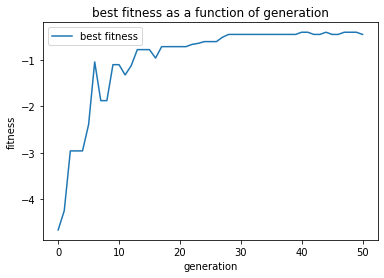

In [14]:
# Plot best fitness as a function of generation
plt.plot(max_fitness, label="best fitness")
plt.legend(loc="upper left")
plt.title("best fitness as a function of generation")
plt.xlabel("generation")
plt.ylabel("fitness")
plt.show()

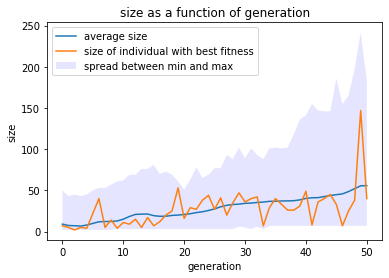

In [15]:
# Plot size as a function of generation
plt.plot(avg_size, label="average size")
plt.fill_between(np.arange(0,51,1), min_size, max_size, facecolor="blue", alpha=0.1, label="spread between min and max")
plt.plot(best_size, label="size of individual with best fitness")
plt.legend(loc="upper left")
plt.title("size as a function of generation")
plt.xlabel("generation")
plt.ylabel("size")
plt.show()